In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from nn_class import bert_lstm_class, irony_detection_class
import warnings
warnings.filterwarnings("ignore")


In [4]:
def irony_detection(test_comment_list):
    class IronyModelConfig:
        batch_size = 32
        output_size = 2
        hidden_dim = 384  # 768/2
        n_layers = 2
        lr = 2e-5
        bidirectional = True  # 这里为True，为双向LSTM
        # training params
        epochs = 5
        # batch_size=50
        print_every = 10
        clip = 5  # gradient clipping
        bert_path = 'model/bert-base-chinese/'  # 预训练bert路径
        save_path = 'model/irony_detection_bert_bilstm.pth'  # 模型保存路径
        load_path = 'model/back/irony_detection_bert_bilst[5-10K_fold].pth'
        disable_warnings = True
        random_seed = 0
        use_cuda = torch.cuda.is_available()
        USE_CUDA = torch.cuda.is_available()
        # use_cuda = False
        data_path = 'datasets/BV12i42167pY1.csv'
        pre_token_name = 'bert-base-chinese'
    config = IronyModelConfig()
    
    
    
    
    net = bert_lstm_class.bert_lstm(config.bert_path,
                                    config.hidden_dim,
                                    config.output_size,
                                    config.n_layers,
                                    config.use_cuda,
                                    config.bidirectional)
    net.load_state_dict(torch.load(config.load_path))
    net.cuda()
    result_comments = bert_lstm_class.pretreatment(test_comment_list) # 预处理去掉标点符号
    # 转换为字id
    tokenizer = BertTokenizer.from_pretrained(config.bert_path)
    result_comments_id = tokenizer(result_comments,
                                   padding=True,
                                   truncation=True,
                                   max_length=120,
                                   return_tensors='pt')
    tokenizer_id = result_comments_id['input_ids']
    attention_mask = result_comments_id['attention_mask']
    token_type_ids = result_comments_id['token_type_ids']
    inputs = tokenizer_id
    batch_size = inputs.size(0)
    # batch_size = 32
    # initialize hidden state
    h = net.init_hidden(batch_size)

    if config.USE_CUDA:
        inputs = inputs.cuda()
        attention_mask = attention_mask.cuda()
        token_type_ids = token_type_ids.cuda()

    net.eval()
    with torch.no_grad():
        # get the output from the model
        output = net(inputs, h, attention_mask, token_type_ids)
        output = torch.nn.Softmax(dim=1)(output)
        pred = torch.max(output, 1)[1]

    return_ls = []
    pred_ls = []
    for each_output in output:
        return_ls.append(float('{:.4f}'.format(torch.max(each_output, 0)[0].item())))
    for each_pred in pred:
        pred_ls.append(each_pred.item())
    return return_ls, pred_ls

In [12]:
r = irony_detection(['我们原神游戏世界第一', '玩圆神导致的', '起飞！！'])
r

([0.7575, 0.7539, 0.6404], [1, 0, 0])

In [50]:
r = irony_detection(['我们原神游戏世界第一', '玩圆神导致的', '起飞！！', '我们原神游戏世界第一个屁'])
r

tensor([[ 101, 2769,  812, 1333, 4868, 3952, 2767,  686, 4518, 5018,  671,  102,
            0,    0],
        [ 101, 4381, 1749, 4868, 2193, 5636, 4638,  102,    0,    0,    0,    0,
            0,    0],
        [ 101, 6629, 7607,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 101, 2769,  812, 1333, 4868, 3952, 2767,  686, 4518, 5018,  671,  702,
         2230,  102]])
torch.Size([4, 14])


([0.7557, 0.7538, 0.6408, 0.7028], [1, 0, 0, 1])

In [5]:
def sentiment_analysis(test_comment_list):
    class SentimentModelConfig:
        batch_size = 32
        output_size = 2
        hidden_dim = 384  # 768/2
        n_layers = 2
        lr = 2e-5
        bidirectional = True  # 这里为True，为双向LSTM
        # training params
        epochs = 5
        # batch_size=50
        print_every = 10
        clip = 5  # gradient clipping
        bert_path = 'model/bert-base-chinese/'  # 预训练bert路径
        save_path = 'model/sentiment_analysis_bert_bilstm.pth'  # 模型保存路径
        load_path = 'model/sentiment_analysis_bert_bilstm[1-10K_fold].pth'
        disable_warnings = True
        random_seed = 0
        use_cuda = torch.cuda.is_available()
        USE_CUDA = torch.cuda.is_available()
        # use_cuda = False
        data_path = 'datasets/BV12i42167pY1.csv'
        pre_token_name = 'bert-base-chinese'
    config = SentimentModelConfig()
    
    
    def pretreatment(comments):
        result_comments = []
        punctuation = '。，？！：%&~（）、；“”&|,.?!:%&~();""'
        for comment in comments:
            comment = ''.join([c for c in comment if c not in punctuation])
            comment = ''.join(comment.split())  # \xa0
            result_comments.append(comment)
        return result_comments
    
    net = bert_lstm_class.bert_lstm(config.bert_path,
                                    config.hidden_dim,
                                    config.output_size,
                                    config.n_layers,
                                    config.use_cuda,
                                    config.bidirectional)
    net.load_state_dict(torch.load(config.load_path))
    net.cuda()
    result_comments = pretreatment(test_comment_list)  # 预处理去掉标点符号
    # 转换为字id
    tokenizer = BertTokenizer.from_pretrained(config.bert_path)
    result_comments_id = tokenizer(result_comments,
                                   padding=True,
                                   truncation=True,
                                   max_length=120,
                                   return_tensors='pt')
    tokenizer_id = result_comments_id['input_ids']
    attention_mask = result_comments_id['attention_mask']
    token_type_ids = result_comments_id['token_type_ids']
    inputs = tokenizer_id
    batch_size = inputs.size(0)
    # batch_size = 32
    # initialize hidden state
    h = net.init_hidden(batch_size)

    if config.USE_CUDA:
        inputs = inputs.cuda()
        attention_mask = attention_mask.cuda()
        token_type_ids = token_type_ids.cuda()

    net.eval()
    with torch.no_grad():
        # get the output from the model
        output = net(inputs, h, attention_mask, token_type_ids)
        output = torch.nn.Softmax(dim=1)(output)
        pred = torch.max(output, 1)[1]

    return_ls = []
    pred_ls = []
    for each_output in output:
        return_ls.append(float('{:.4f}'.format(torch.max(each_output, 0)[0].item())))
    for each_pred in pred:
        pred_ls.append(each_pred.item())
    return return_ls, pred_ls

In [54]:
r = sentiment_analysis(['我们原神游戏世界第一', '玩圆神导致的', '起飞！！'])
r

tensor([[ 101, 2769,  812, 1333, 4868, 3952, 2767,  686, 4518, 5018,  671,  102],
        [ 101, 4381, 1749, 4868, 2193, 5636, 4638,  102,    0,    0,    0,    0],
        [ 101, 6629, 7607,  102,    0,    0,    0,    0,    0,    0,    0,    0]])
torch.Size([3, 12])


([0.7356, 0.6644, 0.6007], [1, 0, 1])

In [13]:
r = sentiment_analysis(['我们原神游戏世界第一', '玩圆神导致的', '起飞！！', '这是什么', '打死你喵'])
r

tensor([0.2644, 0.7356], device='cuda:0')
tensor(0.7356, device='cuda:0')
tensor([0.6644, 0.3356], device='cuda:0')
tensor(0.6644, device='cuda:0')
tensor([0.3992, 0.6008], device='cuda:0')
tensor(0.6008, device='cuda:0')
tensor([0.7618, 0.2382], device='cuda:0')
tensor(0.7618, device='cuda:0')
tensor([0.6697, 0.3303], device='cuda:0')
tensor(0.6697, device='cuda:0')


([0.7356, 0.6644, 0.6008, 0.7618, 0.6697], [1, 0, 1, 0, 0])

In [14]:
unkonw_comment_ls = pd.read_csv('datasets/BV12i42167pY1.csv', encoding='ansi').head(20)
unkonw_comment_ls

,Comment_ID,Comment_Name,Comment_Content,Comment_Time,简单标签,情感标签,讽刺标签1,讽刺标签2
0,4.734421e+08,括号删干净啊,绝世好活 近半年来看过最好的活,2024/7/22,NaN,0,2,2
1,1.113020e+09,每天都要看兔女郎跳舞,[抱拳]米站是这样的，用户只需要发信息就好了，而米站要考虑的就多了。删谁的评论，不删谁的评论...,2024/7/22,NaN,2,2,2
2,1.322819e+07,垣也_,抛开事实不谈，这剧情难道不好嘛？自律人一天闹麻了，我双手双脚支持策划多来点[喜欢],2024/7/22,NaN,2,2,2
3,4.296435e+08,30449007305_bili,原神这都是被带节奏的，故意抹黑的，这次剧情非常好，我也十分喜欢，刚好5.0马上来了，是入坑原...,2024/7/23,NaN,2,2,2
4,7.030607e+08,额滴可汗,无条件支持米哈游公司的一切决议！谁能有意见？谁敢有意见！！！,2024/7/22,NaN,2,2,2
5,3.828526e+07,beandre,我牙刷，反观长离剧情，纯爽啊家人们,2024/7/22,NaN,2,2,2
6,3.570996e+07,夏伍君,懂不懂见证者摄像头的含义！他就像是av中醉酒熟睡的丈夫，电车上装聋作哑的路人，可以没用！但不...,2024/7/22,NaN,2,2,2
7,4.910618e+08,摸鱼的郭嘉,最近节奏真多啊，只能希望原神策划不要被这些节奏带偏，安心做自己想做的，我觉得原神现在的设计完...,2024/7/25,NaN,2,2,2
8,3.099657e+08,醉郎漫卷春秋梦,都是在带节奏，这剧情我觉得挺好，怎么就不好了，反对的人都是没好好看剧情。[给心心],2024/7/22,NaN,2,2,2
9,1.101399e+08,攀爱小小罗,我要给赔宝道歉，4.8活动让我对赔宝改观了，它对黄毛是真的好，不仅救下了忘了风之翼怎么用的黄...,2024/7/23,NaN,2,2,2


In [28]:
# 对未知评论进行情感分析与讽刺分析并绘制四象限图
def plot_four_quadrant(data_path, number_of_comments=None, verbose=False):
    import matplotlib.pyplot as plt
    import pandas as pd
    
    if number_of_comments is None:
        unkonw_comment_ls = pd.read_csv(data_path, encoding='ansi')['Comment_Content'].tolist()        
    else:
        unkonw_comment_ls = pd.read_csv(data_path, encoding='ansi').head(number_of_comments)['Comment_Content'].tolist()
    # for comment_str in tqdm(unkonw_comment_ls):
    sentiment_score_ls, sentiment_label_ls = sentiment_analysis(unkonw_comment_ls)
    irony_score_ls, irony_label_ls = irony_detection(unkonw_comment_ls)
    for i in range(len(unkonw_comment_ls)):
        sentiment_score, sentiment_label = sentiment_score_ls[i], sentiment_label_ls[i]
        irony_score, irony_label = irony_score_ls[i], irony_label_ls[i]
        if verbose:
            print(sentiment_score, sentiment_label, irony_score, irony_label)
        if sentiment_label == 1 and irony_label == 1:
            plt.scatter(sentiment_score-0.5, irony_score-0.5, c='g') 
        elif sentiment_label == 0 and irony_label == 0:
            plt.scatter(-sentiment_score+0.5, -irony_score+0.5, c='r')
        elif sentiment_label == 1 and irony_label == 0:
            plt.scatter(sentiment_score-0.5, -irony_score+0.5, c='yellow')
        elif sentiment_label == 0 and irony_label == 1:
            plt.scatter(-sentiment_score+0.5, irony_score-0.5, c='b')
    # 绘制顶点,保证坐标轴是完整的
    plt.scatter(0, 1, alpha=0)
    # 绘制象限图的坐标名字
    plt.text(0.51, -0.01,'positive',fontsize=14)
    plt.text(-0.74, -0.01,'negative',fontsize=14)
    plt.text(-0.05, 0.53,'irony',fontsize=14)
    plt.text(-0.10, -0.57,'not irony',fontsize=14)
    ax=plt.gca()
    ax.spines['right'].set_color('none') #只保留一条纵坐标轴，形成象限图
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    # 设置x，y等比例
    ax = plt.gca()
    ax.set_aspect(1)
    # 取消刻度线
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('result/fig/sentiment_analysis.png')
    plt.show()
plot_four_quadrant('datasets/BV12i42167pY1.csv', number_of_comments=100, verbose=False)


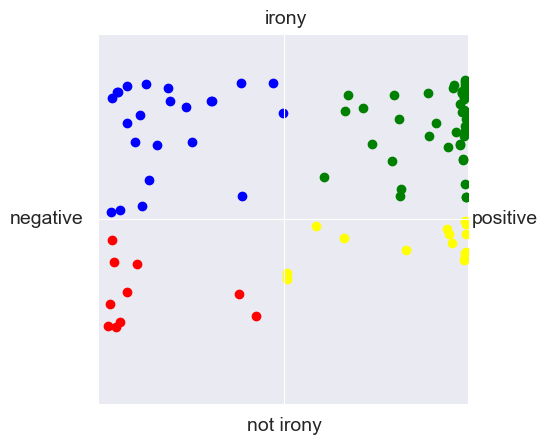

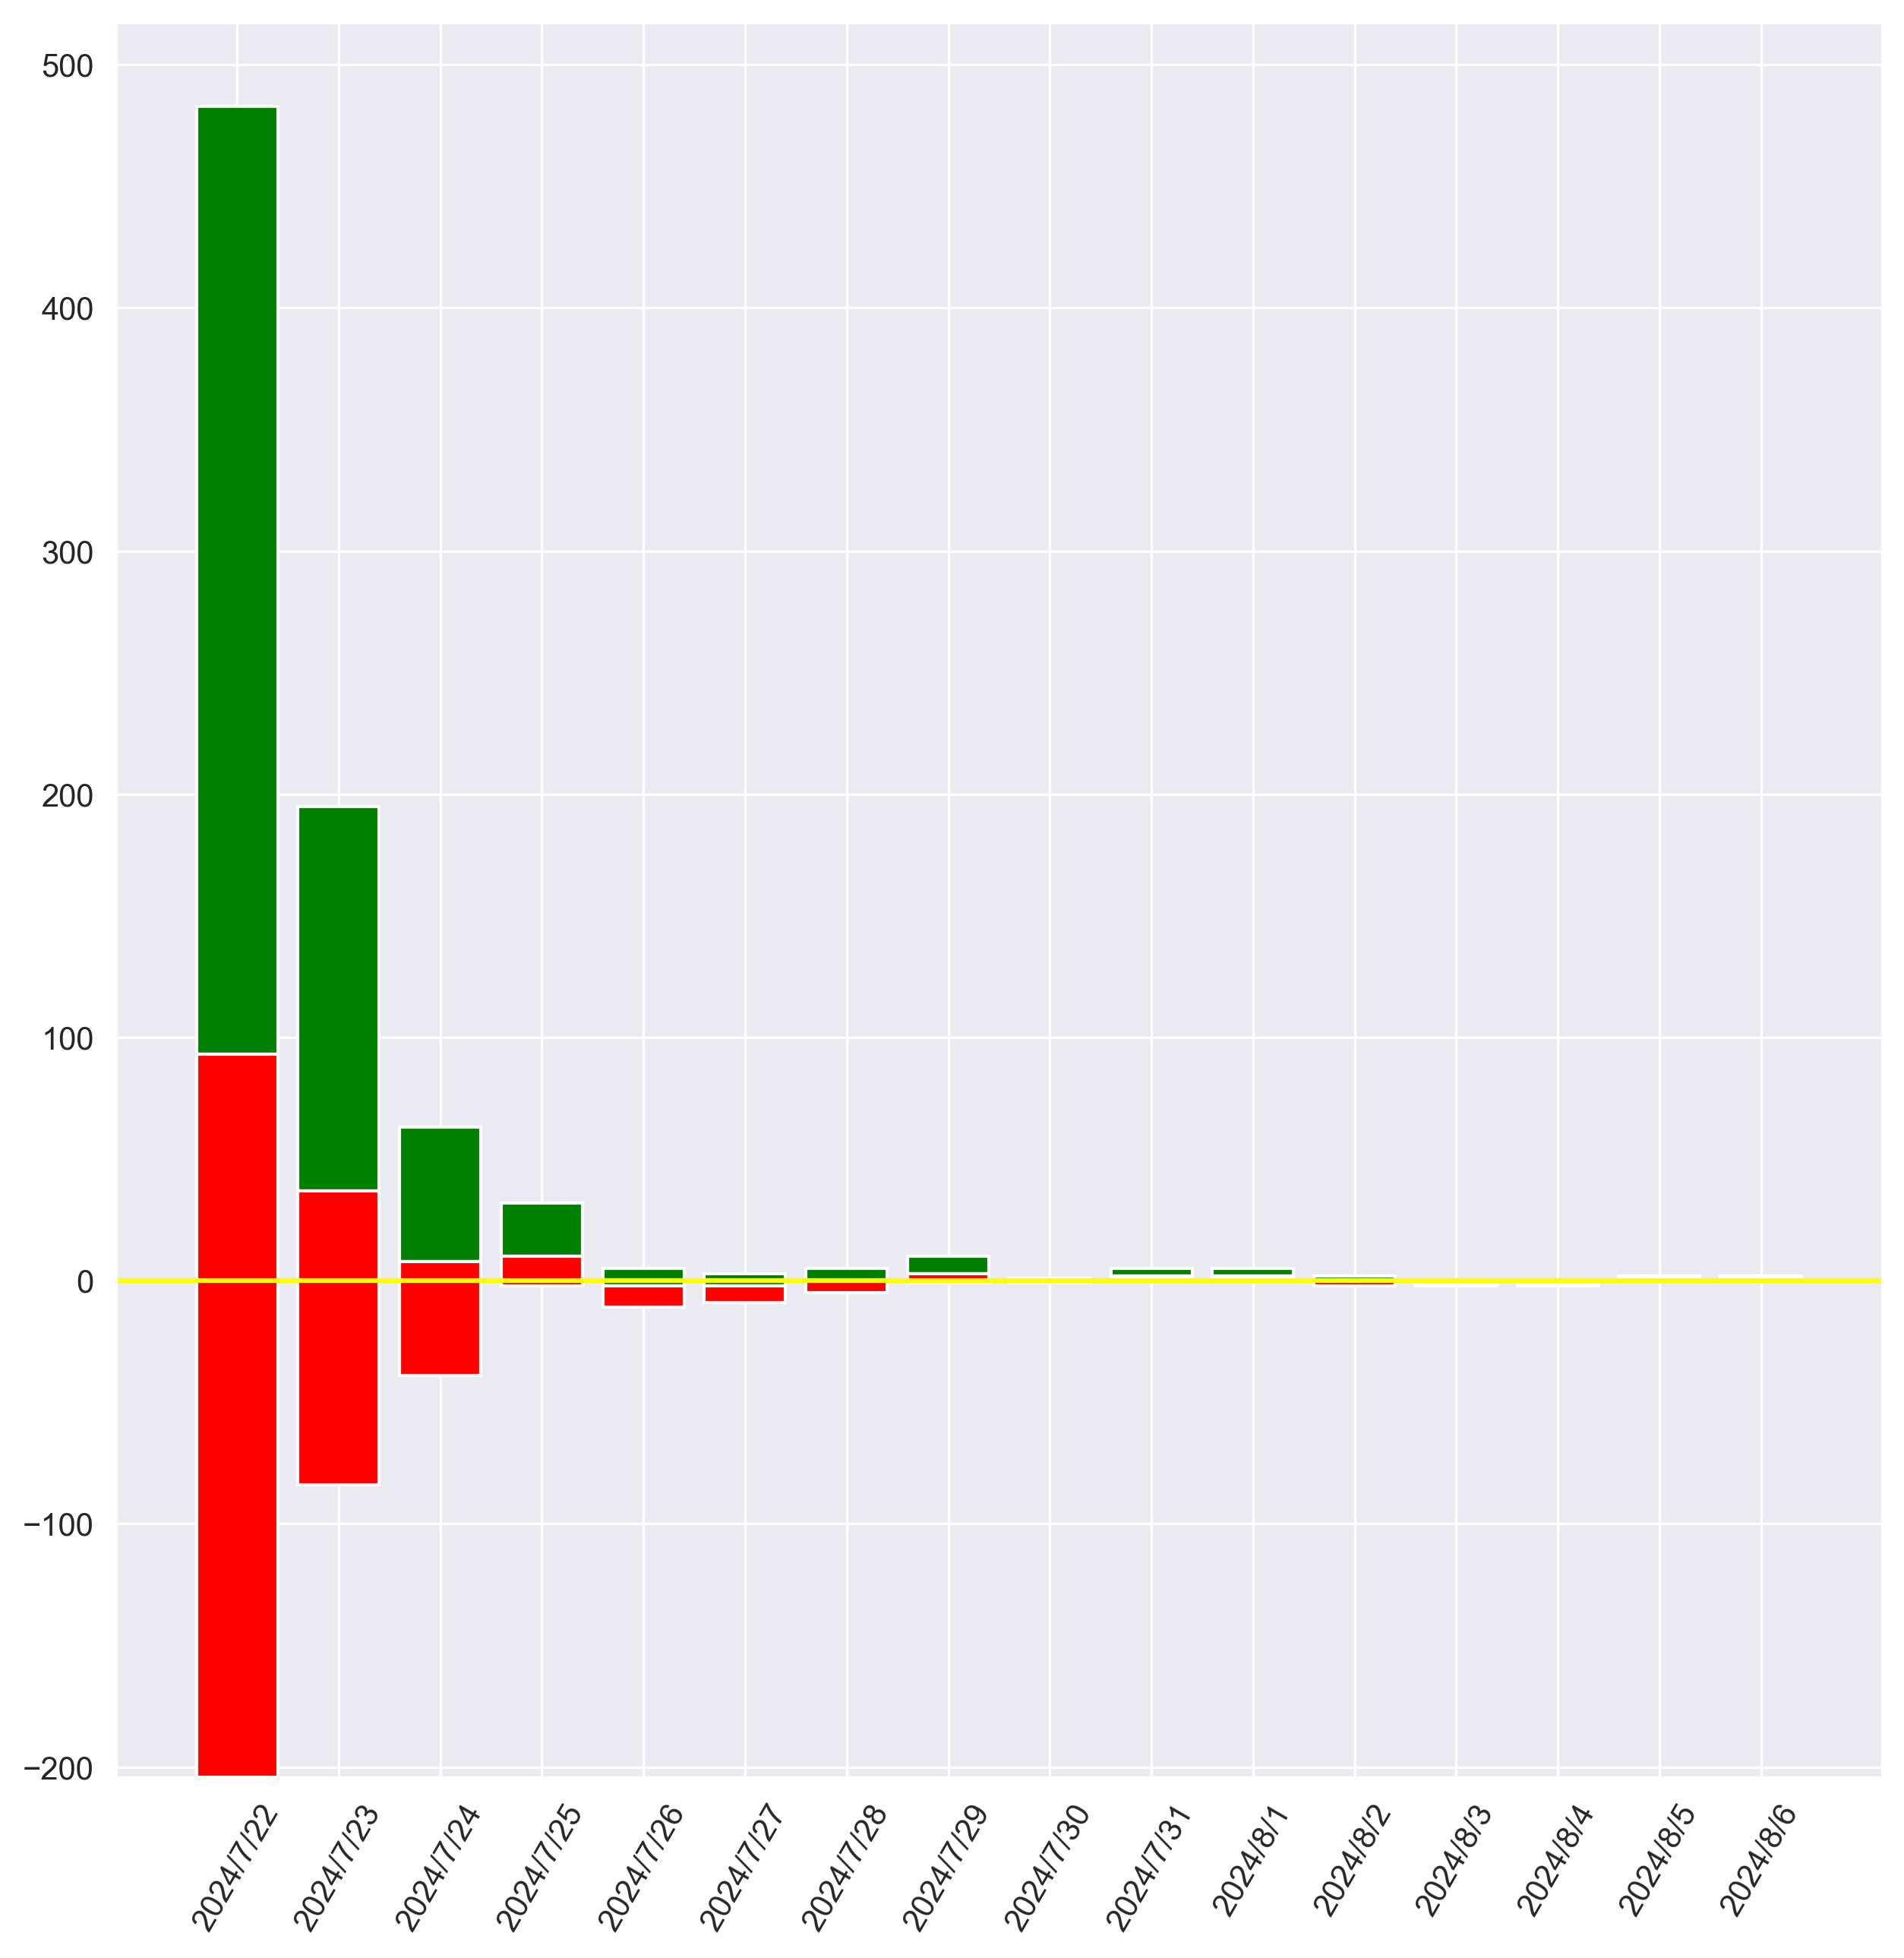

In [27]:
def sentiment_analysis_by_time(data_path, number_of_comments=None):
    # 导入包
    import matplotlib.pyplot as plt
    # 读取文件
    if number_of_comments is None:
        df = pd.read_csv(data_path, encoding='ansi')       
    else:
        df = pd.read_csv(data_path, encoding='ansi').head(number_of_comments)
    # 获得情感标签
    sentiment_score_ls, sentiment_label_ls = sentiment_analysis(df['Comment_Content'].tolist())
    df['sentiment_label'] = sentiment_label_ls
    plt.figure(dpi=300,figsize=(10,10))
    # 按时间分组
    bar_info_ls = []
    for data_str, group_df in df.groupby('Comment_Time'):  # 此处的输出已经自动安装日期排序了
        sentiment_label_ls = group_df['sentiment_label'].tolist()
        positive_n = sentiment_label_ls.count(1)
        negative_n = sentiment_label_ls.count(0)
        total_sentiment = positive_n - negative_n
        bar_info_ls.append([data_str, total_sentiment, positive_n, negative_n])
    # 绘制双向柱状图
    for bar_info in bar_info_ls: 
        x_tick, total_height, positive_height, negative_height = bar_info[0], bar_info[1], bar_info[2], bar_info[3]
        plt.bar(x_tick, positive_height, color='g', bottom=total_height)
        plt.bar(x_tick, negative_height, color='r', bottom=total_height-negative_height)
    # 绘制水平线，水平线以上表示总的评论为积极
    plt.axhline(0, color='yellow')
    # 旋转标签
    plt.xticks(rotation=60)
    plt.savefig('result/fig/comment_by_time.png')
    plt.show()
sentiment_analysis_by_time('datasets/BV12i42167pY1.csv', number_of_comments=None)

In [8]:
data_path = 'datasets/data_topic3.csv'
df = pd.read_csv(data_path)
df

,content,content_cutted,label_name,posibility
0,念sc的时候可以加个字幕显示sc内容，效果更好,时候 字幕 内容 效果,剧情_摄像头_角色,[0.25233553 0.74766447]
1,饭都吃完了，你才更新是吧??,饭,未知,[0.5 0.5]
2,[滑稽]讲真的 。如果准备好文案再来做视频观感会比现在更好！但是直播配合sc比直接念稿子更爽,文案 视频 观感 直播 稿子,剧情_摄像头_角色,[0.49949623 0.50050377]
3,怎么这么多圣经,圣经,未知,[0.5 0.5]
4,摄像头这么能睡是不是玩??玩的[呲牙],摄像头 牙,剧情_摄像头_角色,[0.25023129 0.74976871]
...,...,...,...,...
1164,第一,NaN,未知,[0.5 0.5]
1165,前十[doge],NaN,未知,[0.5 0.5]
1166,前排[doge],NaN,未知,[0.5 0.5]
1167,[doge][doge][doge],NaN,未知,[0.5 0.5]


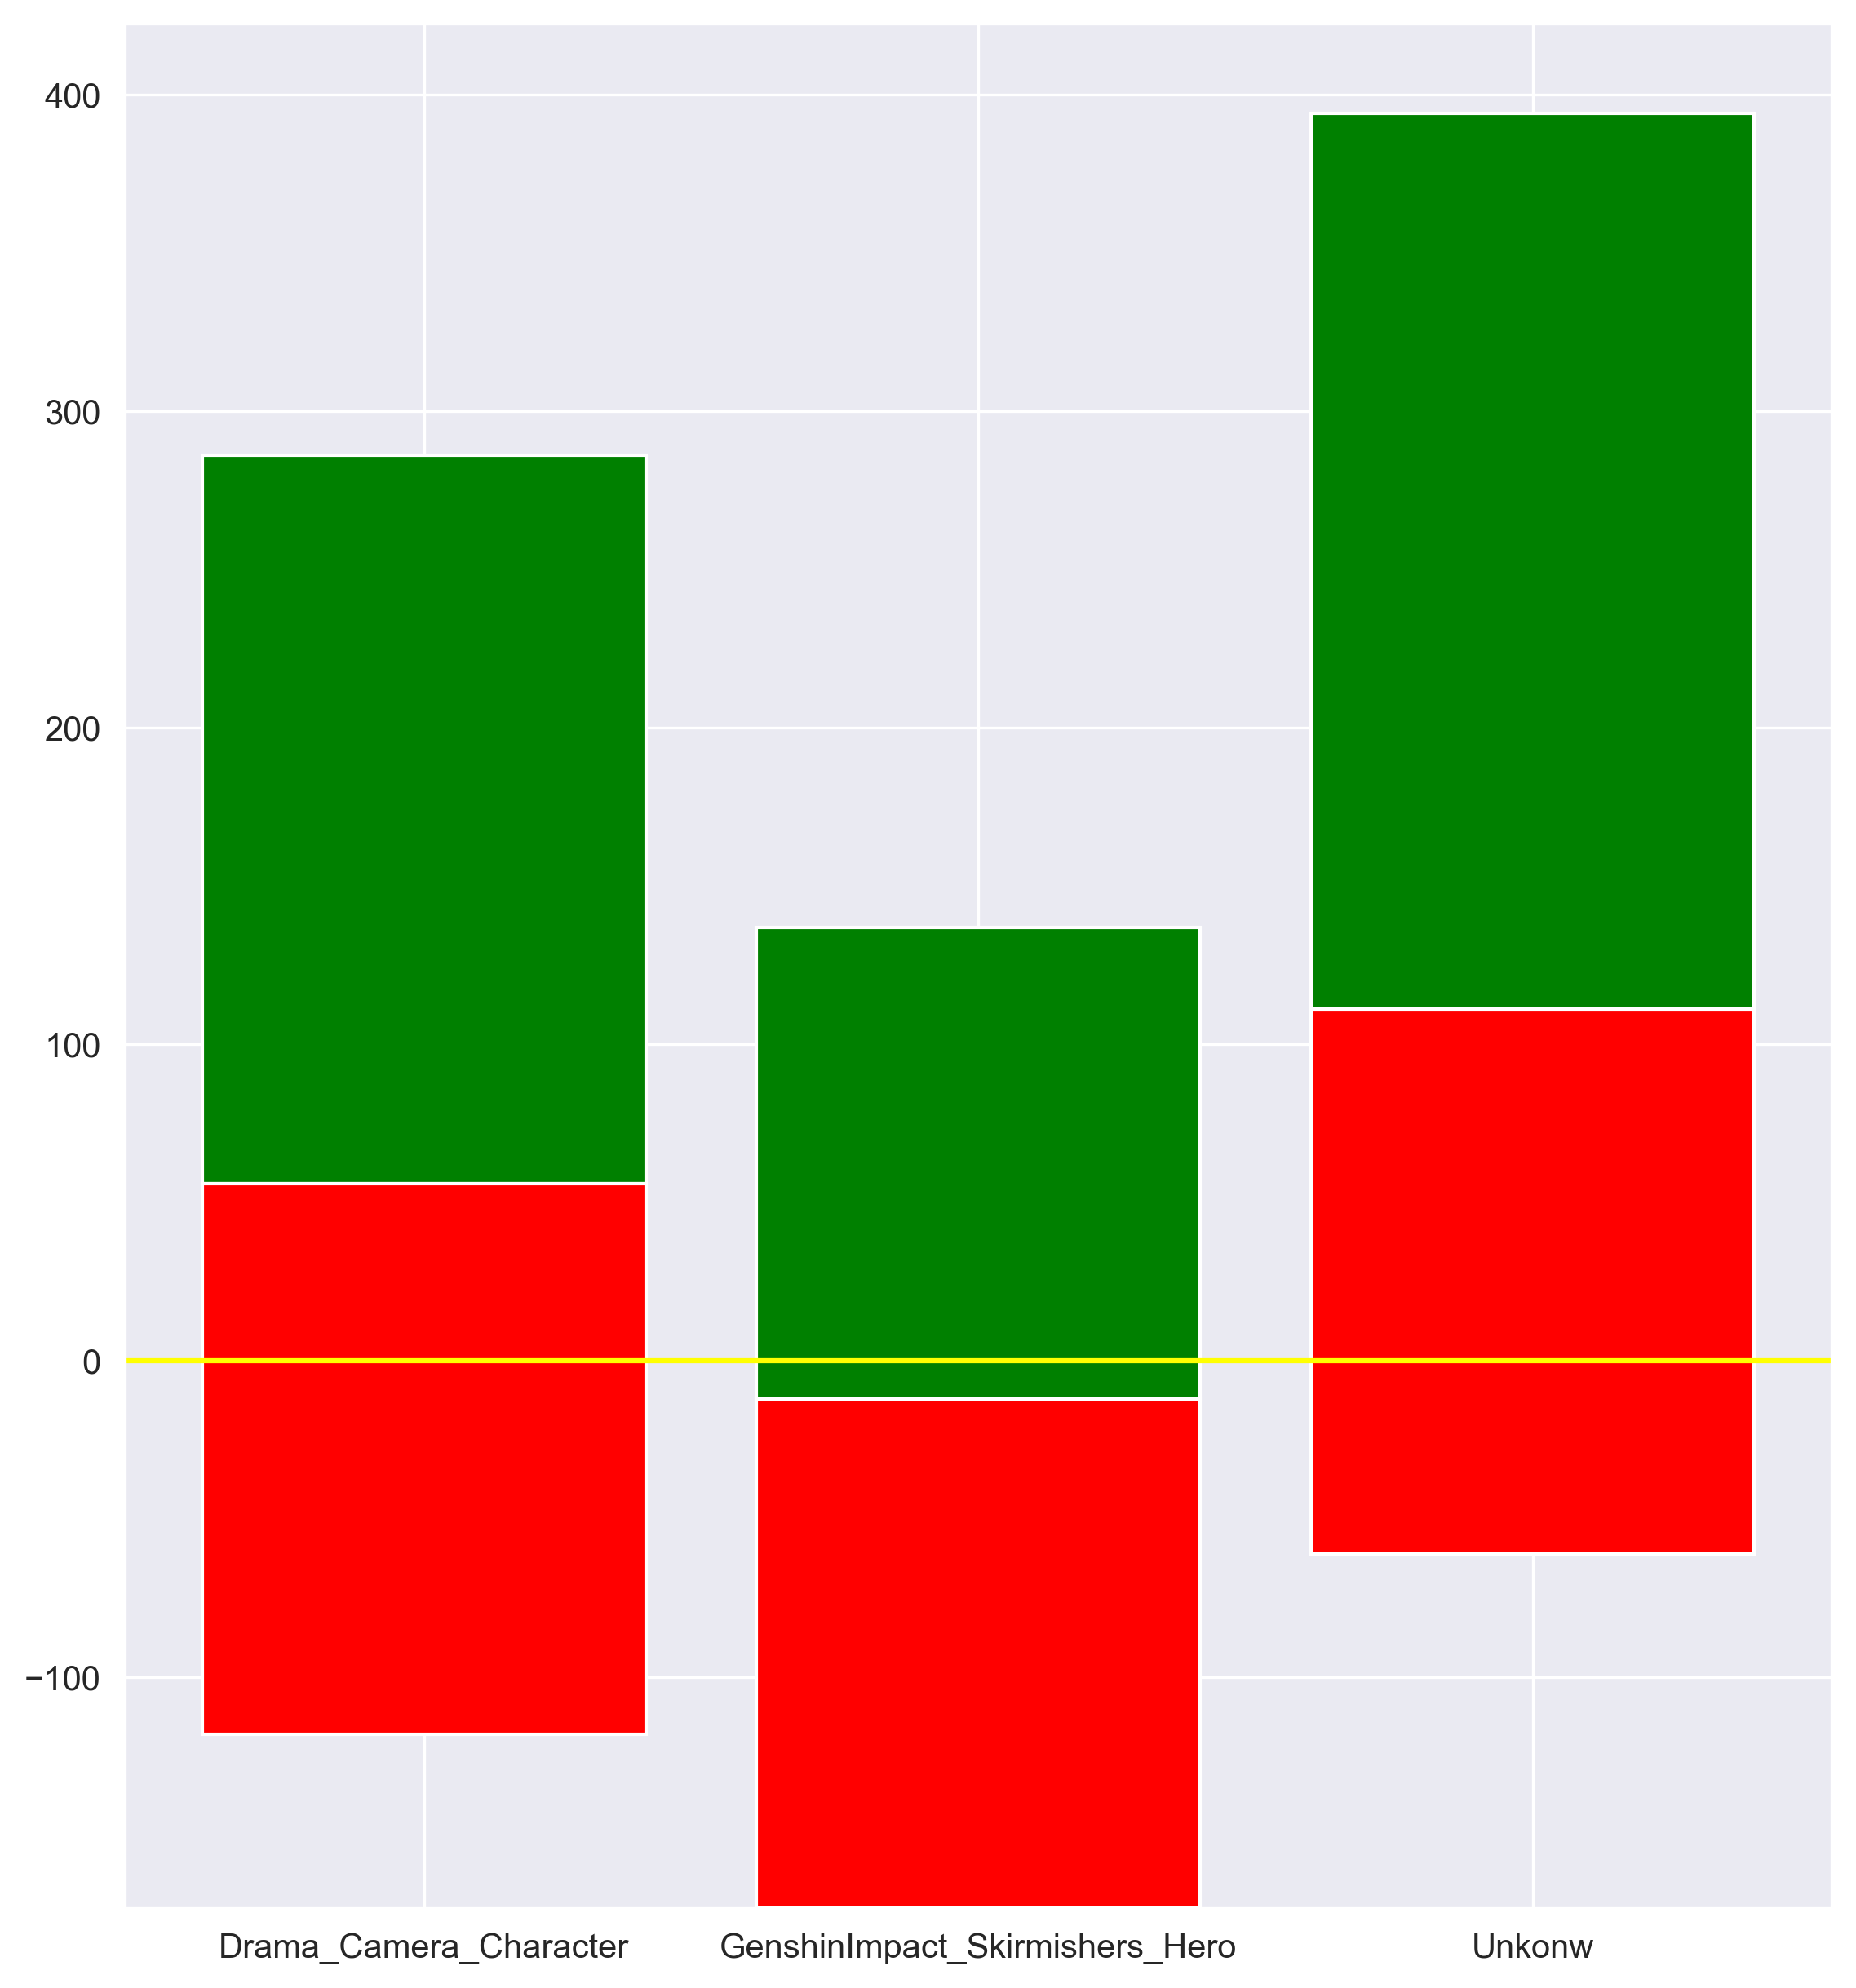

In [19]:
def sentiment_analysis_by_topic(data_path, number_of_comments=None):
    # 导入包
    import matplotlib.pyplot as plt
    # 读取文件
    if number_of_comments is None:
        df = pd.read_csv(data_path)       
    else:
        df = pd.read_csv(data_path).head(number_of_comments)
    # 获得情感标签
    sentiment_score_ls, sentiment_label_ls = sentiment_analysis(df['content'].tolist())
    df['sentiment_label'] = sentiment_label_ls
    # 按时间分组
    bar_info_ls = []
    plt.figure(dpi=300,figsize=(9,10))
    for data_str, group_df in df.groupby('label_name'):  # 此处的输出已经自动安装日期排序了
        sentiment_label_ls = group_df['sentiment_label'].tolist()
        positive_n = sentiment_label_ls.count(1)
        negative_n = sentiment_label_ls.count(0)
        total_sentiment = positive_n - negative_n
        if data_str == '剧情_摄像头_角色':
            data_str = 'Drama_Camera_Character'
        elif data_str == '原神_散兵_主角':
            data_str = 'GenshinImpact_Skirmishers_Hero'
        elif data_str == '未知':
            data_str = 'Unkonw'
        bar_info_ls.append([data_str, total_sentiment, positive_n, negative_n])
    # 绘制双向柱状图
    for bar_info in bar_info_ls: 
        x_tick, total_height, positive_height, negative_height = bar_info[0], bar_info[1], bar_info[2], bar_info[3]
        plt.bar(x_tick, positive_height, color='g', bottom=total_height)
        plt.bar(x_tick, negative_height, color='r', bottom=total_height-negative_height)
    # 绘制水平线，水平线以上表示总的评论为积极
    plt.axhline(0, color='yellow')
    # 旋转标签
    # plt.xticks(rotation=60)
    plt.savefig('result/fig/comment_by_topic.png')
    plt.show()
sentiment_analysis_by_topic('datasets/data_topic3.csv', number_of_comments=None)